In [19]:
import sys

sys.path.append("/home/ji-liu/GitHub/off_road_nav/")

INFO     - 2025-11-12 18:09:51 - polar_bev_transform.py:34 - <module>() - bev_pool imported successfully


In [20]:
from offroad_det_seg_rellis.bev_former.polar_bev_transform import (
    PolarBEVTransform,
)

In [21]:
from offroad_det_seg_rellis.dataset.rellis_sequence import get_rellis_sequence

sequence = get_rellis_sequence(
    sequence_root="/home/ji-liu/GitHub/off_road_nav/RELLIS/Rellis-3D",
    sequence_id="00000",
)

In [4]:
sequence.RT_lidar2cam

array([[ 0.03462246,  0.99936056, -0.00893175, -0.0356621 ],
       [ 0.00479177, -0.00910301, -0.9999471 , -0.17154603],
       [-0.99938893,  0.03457784, -0.00510388, -0.13379309],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [5]:
sequence.R_lidar2cam

array([[ 0.03462246,  0.99936056, -0.00893175],
       [ 0.00479177, -0.00910301, -0.9999471 ],
       [-0.99938893,  0.03457784, -0.00510388]], dtype=float32)

In [6]:
sequence.t_lidar2cam

array([-0.0356621 , -0.17154603, -0.13379309], dtype=float32)

In [7]:
sequence.camera_intrinsics

array([[2.8136433e+03, 0.0000000e+00, 9.6928577e+02],
       [0.0000000e+00, 2.8083262e+03, 6.2404999e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [22]:
import pprint
config = sequence.load_bev_seg_config(grid_type="polar")
pprint.pprint(config)

{'angle_edges': [2.7827837467193604,
                 2.8545455932617188,
                 2.926307439804077,
                 2.9980690479278564,
                 3.069830894470215,
                 3.1415927410125732,
                 3.2133545875549316,
                 3.28511643409729,
                 3.3568782806396484,
                 3.4286398887634277,
                 3.500401735305786],
 'angle_range': [2.7827837467193604, 3.500401735305786],
 'angle_resolution': 0.07176180183887482,
 'radial_edges': [5.0,
                  5.25,
                  5.512499809265137,
                  5.787499904632568,
                  6.074999809265137,
                  6.375,
                  6.6875,
                  7.012499809265137,
                  7.349999904632568,
                  7.699999809265137,
                  8.0625,
                  8.4375,
                  8.824999809265137,
                  9.225000381469727,
                  9.637499809265137,
               

In [23]:
# Configuration
B, N = 1, 1  # Batch size=1, 1 camera
C_in, C_out = 128, 64

img_h, img_w = sequence.get_image_size()
img_size = (img_h, img_w)
print(img_h, img_w)
feat_size = (img_h // 16, img_w // 16)
print(feat_size)

1200 1920
(75, 120)


In [24]:
transform = PolarBEVTransform(
        in_channels=C_in,
        out_channels=C_out,
        image_size=img_size,
        feature_size=feat_size,
        polar_grid_config=config,
        dbound=(1.0, 27.0, 0.5),
        downsample=1,
    )

Camera to LiDAR transformation:
R_cam2lidar:
[[ 0.03462247  0.00479177 -0.999389  ]
 [ 0.99936056 -0.00910301  0.03457784]
 [-0.00893176 -0.9999471  -0.00510388]]
t_cam2lidar: [-0.13165462  0.03870398 -0.17253834]
Using GPU



Running forward pass...


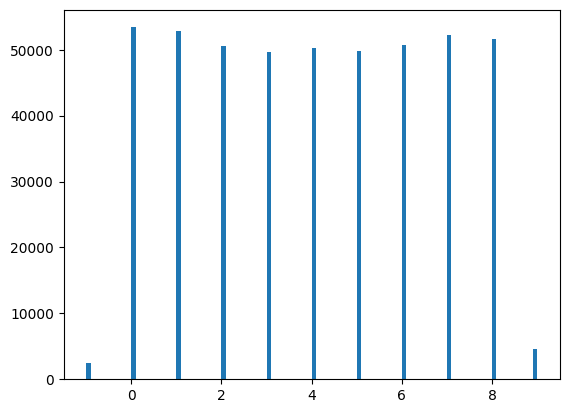

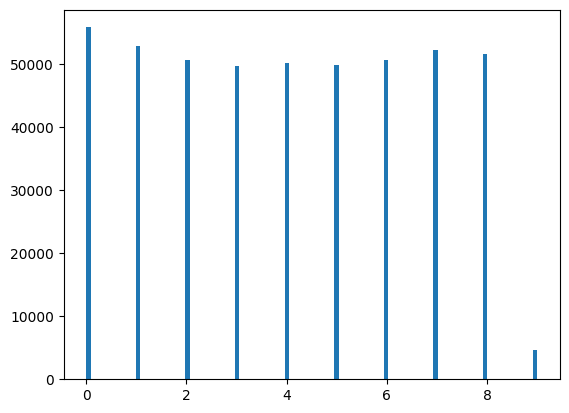

Success! BEV features shape: torch.Size([1, 64, 41, 10])


In [26]:
import torch
from einops import repeat
from offroad_det_seg_rellis.dataset.bev_visualization import visualize_bev_polar

# First, let's check the camera-to-lidar transformation
print("Camera to LiDAR transformation:")
print(f"R_cam2lidar:\n{sequence.R_cam2lidar}")
print(f"t_cam2lidar: {sequence.t_cam2lidar}")

# Create dummy inputs
img_feats = torch.randn(B, N, C_in, *feat_size)

# n is the number of cameras
camera2lidar_rots = repeat(torch.from_numpy(sequence.R_cam2lidar), "d1 d2 -> b n d1 d2", b=B, n=N)
camera2lidar_trans = repeat(torch.from_numpy(sequence.t_cam2lidar), "d1 -> b n d1", b=B, n=N)
K = repeat(torch.from_numpy(sequence.camera_intrinsics), "d1 d2 -> b n d1 d2", b=B, n=N)

# No augmentation
img_aug = repeat(torch.eye(4), "d1 d2 -> b n d1 d2", b=B, n=N)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU")

img_feats = img_feats.to(device)
camera2lidar_rots = camera2lidar_rots.to(device)
camera2lidar_trans = camera2lidar_trans.to(device)
K = K.to(device)
img_aug = img_aug.to(device)

transform = transform.to(device)

print("\nRunning forward pass...")
print("="*60)
with torch.no_grad():
    bev_feats = transform(
        img=img_feats,
        camera2lidar_rots=camera2lidar_rots,
        camera2lidar_trans=camera2lidar_trans,
        camera_intrinsics=K,
        img_aug_matrix=img_aug,
        
    )

print("="*60)
print(f"Success! BEV features shape: {bev_feats.shape}")



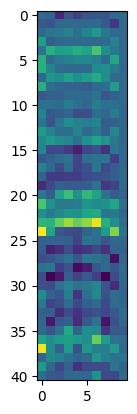

In [27]:
import matplotlib.pyplot as plt

# Visualize one sample
bev_feat_sample = bev_feats[0, 4, :, :].squeeze().cpu().numpy()

plt.figure()
plt.imshow(bev_feat_sample)
plt.show()